# Pyiron workflows: Introduction and Syntax

Here we will highlight:
- How to instantiate a node
- How to make reusable node classes
- How to connect node inputs and outputs together
- Flow control (i.e. signal channels vs data channels)
- Defining new nodes from special node classes (Fast and SingleValue)
- The five ways of adding nodes to a workflow
- Using pre-defined nodes 
- Macro nodes

## Instantiating a node

Simple nodes can be defined on-the-fly by passing any callable to the `Function(Node)` class. This transforms the function into a node instance which has input and output, can be connected to other nodes in a workflow, and can run the function it stores.

Input and output channels are _automatically_ extracted from the signature and return value(s) of the function. (Note: "Nodized" functions must have _at most_ one `return` expression!)

In [1]:
from pyiron_contrib.workflow.function import Function

In [2]:
def plus_minus_one(x):
    return x+1, x-1

pm_node = Function(plus_minus_one)

This has automatically created a node with input and output data channels whose labels are gathered by inspecting the function:

In [3]:
print(pm_node.inputs.labels, pm_node.outputs.labels)

['x'] ['x+1', 'x-1']


The output is still empty (`NotData`) because we haven't `run()` the node:

In [4]:
print(pm_node.outputs.to_value_dict())

{'x+1': <class 'pyiron_contrib.workflow.channels.NotData'>, 'x-1': <class 'pyiron_contrib.workflow.channels.NotData'>}


If we try that now though, we'll just get a type error because the input is not set! 

In [5]:
# pm_node.run()
pm_node.update()

Using the softer `update()` call checks to make sure the input is `ready` before moving on to `run()`, avoiding this error. In this case, `update()` sees we have no input an aborts by returning `None`.

(Note: If you _do_ swap `update()` to `run()` in this cell, not only will you get the expected error, but `pm_node` will also set its `failed` attribute to `True` -- this will prevent it from being `ready` again until you manually reset `pm_node.failed = False`.)

In [6]:
# pm_node.failed = False

If we update the input, we'll give the node enough data to work with:

In [7]:
pm_node.inputs.x = 5
pm_node.run()
print(pm_node.outputs.to_value_dict())

{'x+1': 6, 'x-1': 4}


Alternatively, the `run()` command (and `update()` when it proceeds to execution) just return the function's return value:

In [8]:
out = pm_node.run()
out

(6, 4)

We can give our function defaults so that it's ready to go from the beginning. Let's also take the opportunity to give our output channel a better name so we can get it by dot-access.

In [9]:
def adder(x: int = 0, y: int = 1) -> int:
    sum_ = x + y
    return sum_

adder_node = Function(adder)
adder_node.run()
adder_node.outputs.sum_.value  # We use `value` to see the data the channel holds

1

This node also exploits type hinting! `run()` will always force the execution, but `update()` will not only check if the data is there, but also if it is the right type:

In [10]:
adder_node.inputs.x = "not an integer"
adder_node.inputs.x.type_hint, type(adder_node.inputs.x.value)
adder_node.update()
# No error because the update doesn't trigger a run since the type hint is not satisfied

Since the execution never happened, the output is unchanged

In [11]:
adder_node.outputs.sum_.value

1

Note that assigning data to channels with `=` is actually just syntactic sugar for calling the `update` method of the underlying channel:

In [12]:
adder_node.inputs.x.update(2)
adder_node.update()

3

We can also set new input as any valid combination of kwargs and/or args at both instantiation or on call:

In [13]:
adder_node(10, y=20)
adder_node.run()

30

Finally, we can update input and then `run` together by calling an already-instantiated node. Just like at node instantiation, the input for `Function` nodes can be set by positional and/or keyword argument. Here we'll use two positional args:

In [14]:
adder_node(15, 16)

31

Note for advanced users: when the node has an executor set, running returns a futures object for the calculation, whose `.result()` will eventually be the function output.

## Reusable node classes

If we're going to use a node many times, we may want to define a new sub-class of `Function` to handle this.

The can be done directly by inheriting from `Function` and overriding it's `__init__` function so that the core functionality of the node (i.e. the node function and output labels) are set in stone, but even easier is to use the `function_node` decorator to do this for you! 

The decorator also lets us explicitly choose the names of our output channels by passing the `output_labels` argument to the decorator -- as a string to create a single channel for the returned values, or as a list of strings equal to the number of returned values in a returned tuple.

In [15]:
from pyiron_contrib.workflow.function import function_node

In [16]:
@function_node("diff")
def subtract_node(x: int | float = 2, y: int | float = 1) -> int | float:
    return x - y

sn = subtract_node()
print("class name =", sn.__class__.__name__)
print("label =", sn.label)

sn()  # Runs without updating input data, but we have defaults so that's fine
print("default output =", sn.outputs.diff.value)

class name = SubtractNode
label = subtract_node
default output = 1


# Connecting nodes and controlling flow

Multiple nodes can be used together to build a computational graph, with each node performing a particular operation in the overall workflow:

The input and output of nodes can be chained together by connecting their data channels. When a node runs, its output channels will push their new value to each input node to whom they are connected. In this way, data propagates forwards

In addition to input and output data channels, nodes also have "signal" channels available. Input signals are bound to a callback function (typically one of its node's methods), and output signals trigger the callbacks for all the input signal channels they're connected to.

Standard nodes have a `run` input signal (which is, unsurprisingly, bound to the `run` method), and a `ran` output signal (which, again, hopefully with no great surprise, is triggered at the end of the `run` method.)

In the example below we see how this works for a super-simple toy graph:

In [17]:
@function_node()
def linear(x):
    return x

@function_node("double")
def times_two(x):
    return 2 * x

l = linear()
t2 = times_two()

l.inputs.x = 1
t2.inputs.x = l.outputs.x
t2.signals.input.run = l.signals.output.ran

l.run()
print(t2.inputs.x, t2.outputs.double)

1 2


We can use a couple pieces of syntactic sugar to make this faster.

First: data connections can be made with keyword arguments just like other input data definitions.

Second: the `>` is a shortcut for creating connections between the left-hand node's `signals.output.ran` channel and the right-hand node's `signals.input.run` channel.

With both of these together, we can write:

In [18]:
l = linear(x=10)
t2 = times_two(x=l.outputs.x)
l > t2
l.run()
print(t2.inputs.x, t2.outputs.double)

10 20


We can also chain together the signal fl

In [19]:
import matplotlib.pyplot as plt

## Single Value nodes

Many functions return just a single value. In this case, we can take advantage of the `SingleValue` node class which employs a bunch of syntactic tricks to make our lives easier.

The main difference between this and it's parent the `Function` class is that attribute and item access fall back to looking for attributes and items of this single output value.

Let's look at a use case:

In [20]:
import numpy as np

from pyiron_contrib.workflow.function import SingleValue

In [21]:
def linspace_node(
    start: int | float = 0, stop: int | float = 1, num: int = 50
):
    linspace = np.linspace(start=start, stop=stop, num=num)
    return linspace

lin = SingleValue(linspace_node)
lin.run()

print(type(lin.outputs.linspace.value))  # Output is just what we expect
print(lin[1:4])  # Gets items from the output
print(lin.mean())  # Finds the method on the output -- a special feature of SingleValueNode

<class 'numpy.ndarray'>
[0.02040816 0.04081633 0.06122449]
0.5


The other advantage is that single value nodes can also be connected directly to input, since there is only one possible data connection. Of course it has a construction decorator just like `Function`, so let's replace `@function_node` with `@single_value_node` in one of our examples above to see how it tightens up the syntax a bit:

In [22]:
from pyiron_contrib.workflow.function import single_value_node

@single_value_node()
def linear(x):
    return x

@single_value_node("double")
def times_two(x):
    return 2 * x

l = linear(x=2)
t2 = times_two(x=l)  # Just takes the whole `l` node!
l > t2
l.run()
print(t2)

times_two (TimesTwo) output single-value: 4


In [23]:
@single_value_node()
def noise(length: int = 1):
    array =  np.random.rand(length)
    return array

@function_node()
def plot(x, y):
    fig = plt.scatter(x, y)
    return fig

x = noise(length=10)
y = noise(length=10)
f = plot(x=x, y=y)

Now that the plotting node has run, its input channels are no longer `ready` because they are waiting for a fresh update:

In [24]:
f.inputs.x.ready, f.inputs.y.ready

(False, False)

In [25]:
x.inputs.length = 20
f.inputs.x.ready, f.inputs.y.ready

(False, False)

In [26]:
y.inputs.length = 20

Note that in the second cell, `f` is trying to update itself as soon as its inputs are ready, so if we _hadn't_ set the `f.inputs.y` channel to wait for an update, we would have gotten an error from the plotting command due to the mis-matched lengths of the x- and y-arrays.

# Workflows

The case where we have groups of connected nodes working together is our normal, intended use case.
We offer a formal way to group these objects together as a `Workflow(Node)` object.
`Workflow` also offers us a single point of entry to the codebase -- i.e. most of the time you shouldn't need the node imports used above, because the decorators are available right on the workflow class.

We will also see here that we can our node output channels using the `output_labels: Optional[str | list[str] | tuple[str]` kwarg, in case they don't have a convenient name to start with.
This way we can always have convenient dot-based access (and tab completion) instead of having to access things by string-based keys.

In [27]:
from pyiron_contrib.workflow import Workflow

@Workflow.wrap_as.single_value_node("is_greater")
def greater_than_half(x: int | float | bool = 0) -> bool:
    """The functionality doesn't matter here, it's just an example"""
    return x > 0.5

## Adding nodes to a workflow

All five of the approaches below are equivalent ways to add a node to a workflow. Note that when `create` is called from the workflow _class_ it just gives you access to the class being created; when it is called from a workflow _instance_, it wraps this class so that the created node has its parent value automatically set to the workflow instance that's creating it.

In [28]:
n1 = greater_than_half(label="n1")

wf = Workflow("my_wf", n1)  # As args at init
wf.create.SingleValue(n1.node_function, output_labels="p1", label="n2")  # Instantiating from the class with a function
wf.add(greater_than_half(label="n3"))  # Instantiating then passing to node adder
wf.n4 = greater_than_half(label="will_get_overwritten_with_n4")  # Set attribute to instance
greater_than_half(label="n5", parent=wf)  # By passing the workflow to the node

for i, (label, node) in enumerate(wf.nodes.items()):
    x = i / len(wf)
    node(x=x)
    print(f"{label} == {node.label}) {x} > 0.5 {node.single_value}")

n1 == n1) 0.0 > 0.5 False
n2 == n2) 0.2 > 0.5 False
n3 == n3) 0.4 > 0.5 False
n4 == n4) 0.6 > 0.5 True
n5 == n5) 0.8 > 0.5 True


Workflows have inputs and outputs just like function nodes, but these are dynamically created to map to all _unconnected_ input and output for their underlying graph. They automatically get named by connecting the node label and channel label with a double underscore, but this can be overriden by providing an `inputs_map` and/or an `outputs_map` -- these maps can also let you expose data channels that would otherwise be hidden because they have a connection!

In [29]:
wf = Workflow("simple")

@Workflow.wrap_as.single_value_node()
def add_one(x):
    y = x + 1
    return y

@Workflow.wrap_as.single_value_node("sum")
def add_node(x, y):
    return x + y

wf.a = add_one(0)
wf.b = add_one(0)
wf.sum = add_node(wf.a, wf.b)  
wf.inputs_map = {"a__x": "ax"}
wf.outputs_map = {"a__y": "ay", "sum__sum": "a + b + 2"}
# Remember, with single value nodes we can pass the whole node instead of an output channel!

print(wf.inputs.labels, wf.outputs.labels)

['ax', 'b__x'] ['ay', 'a + b + 2']


When `run()` is called on a workflow, it will search through its owned nodes to see which have no internal data input connections and will call `run()` on each of these -- `a` and `b` in the example above. This behaviour can be overriden by manually setting the `starting_nodes` list attribute.

Remaining execution flow still needs to be defined.

To make sure we don't have a race condition between our branched input, let's use both of these features:

In [30]:
wf.starting_nodes = [wf.a]
wf.a > wf.b > wf.sum

True

Unlike function nodes, workflow input has no intrinsic order. We can still update it by calling the workflow, but we _need_ to use keyword and not positional arguments. Runs of the workflow then return a dot-accessible dictionary based on the output channels:

In [31]:
out = wf(ax=2, b__x=3)
out

{'ay': 3, 'a + b + 2': 7}

We can see now why we've been trying to givesuccinct string labels to our `Function` node outputs instead of just arbitrary expressions! The expressions are typically not dot-accessible:

In [32]:
out["a + b + 2"], out.ay

(7, 3)

We can also look at our graph:

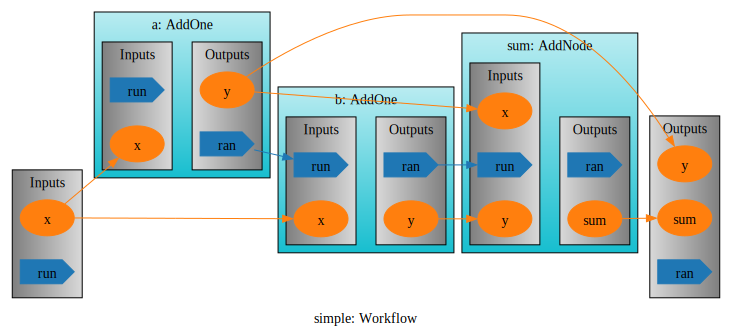

In [33]:
wf.draw()

# Example with pre-built nodes

Currently we have a handfull of pre-build nodes available for import from the `nodes` package. Let's use these to quickly put together a workflow for looking at some MD data.

The job JUSTAJOBNAME was saved and received the ID: 9558


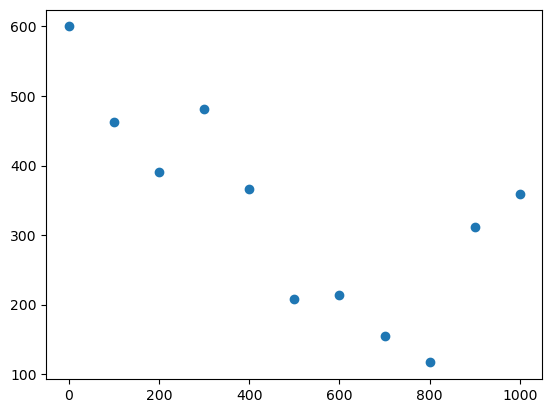

In [34]:
wf = Workflow("with_prebuilt")

wf.structure = wf.create.atomistics.Bulk(cubic=True, name="Al")
wf.engine = wf.create.atomistics.Lammps(structure=wf.structure)
wf.calc = wf.create.atomistics.CalcMd(job=wf.engine)
wf.plot = wf.create.standard.Scatter(
    x=wf.calc.outputs.steps, 
    y=wf.calc.outputs.temperature
)
wf.structure > wf.engine > wf.calc > wf.plot

out = wf.run()
out.plot__fig

Nodes and workflows can be visualized using graphviz:

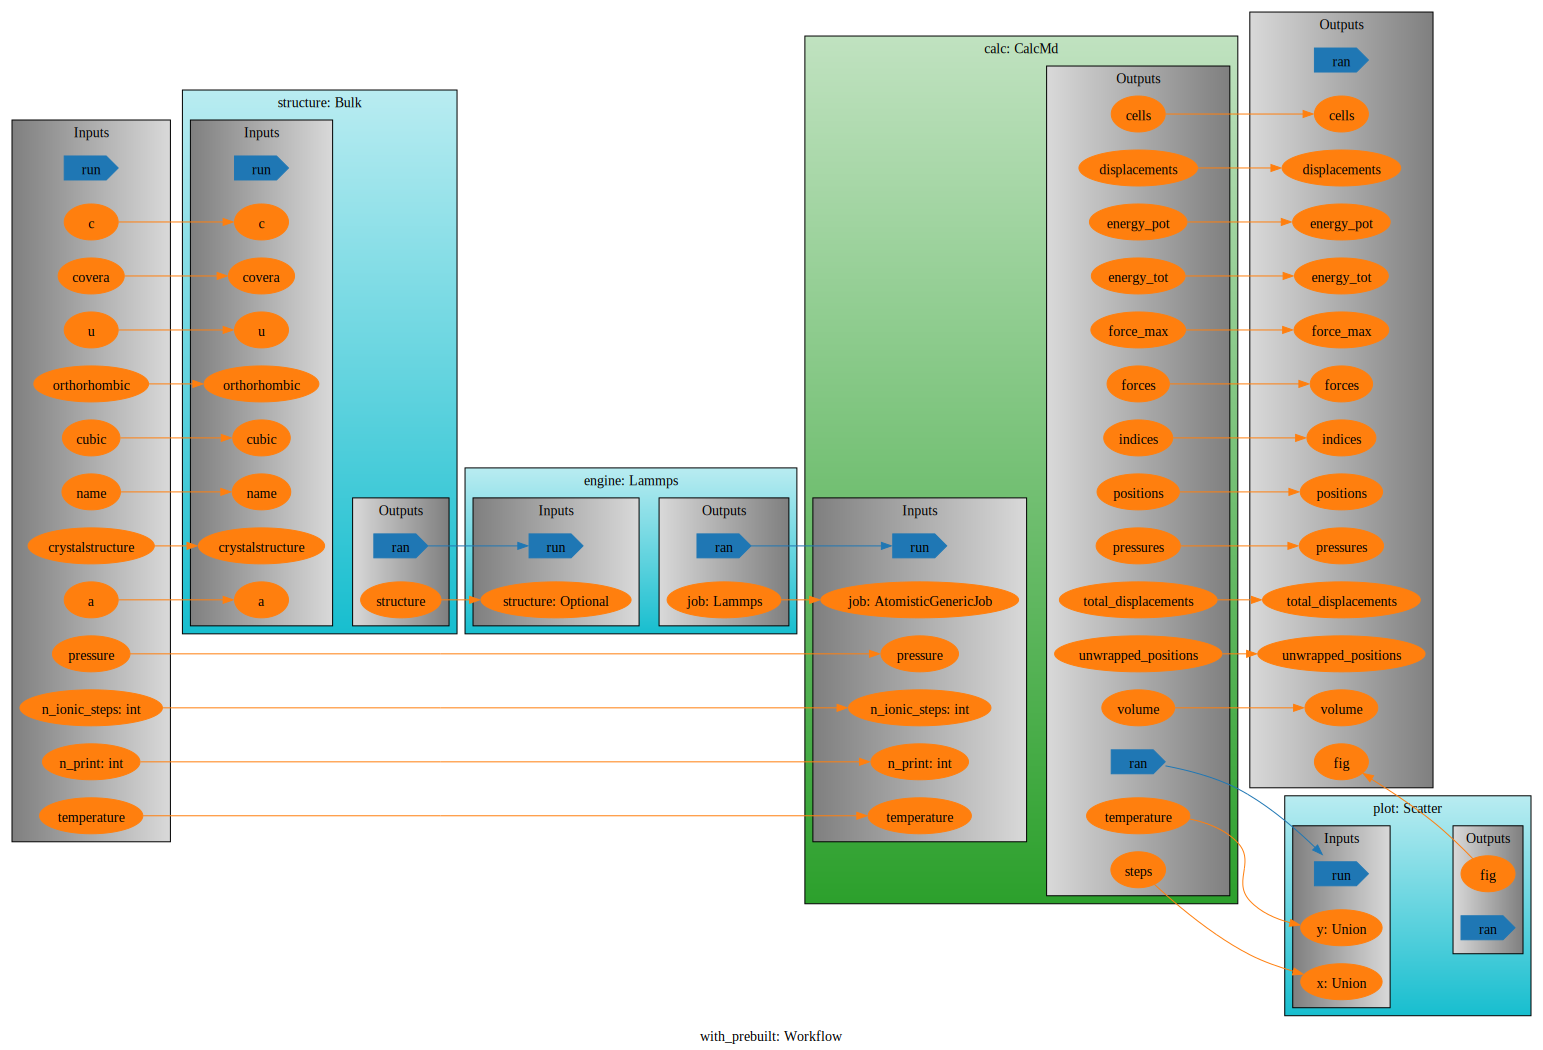

In [35]:
wf.draw()

In case you want to see more or less of the inner workings of the nodes, you can modify the `depth` parameter, which controls how deeply child nodes are decomposed. E.g. we can force our workflow to only show us it's basic IO by setting `depth=0`:

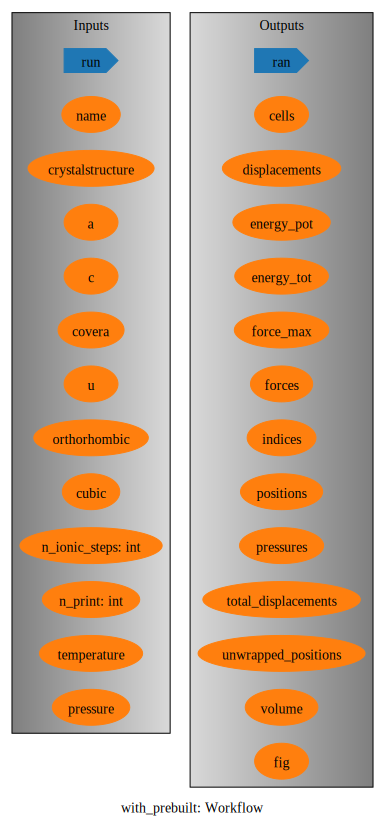

In [36]:
wf.draw(depth=0)

# Macros

Once you have a workflow that you're happy with, you may want to store it as a macro so it can be stored in a human-readable way, reused, and shared. Automated conversion of an existing `Workflow` instance into a `Macro` subclass is still on the TODO list, but defining a new macro is pretty easy: they are just composite nodes that have a function defining their graph setup:

In [37]:
from pyiron_contrib.workflow.macro import Macro

In [38]:
@Workflow.wrap_as.single_value_node("result")
def add_one(x):
    return x + 1

def add_three_macro(macro: Macro) -> None:
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    macro.add_one = add_one(0)
    macro.add_two = add_one(macro.add_one)
    macro.add_three = add_one(macro.add_two)
    # macro.starting_nodes = [macro.add_one]  
    # Setting this starting node is silly, since as the head-most node 
    # it is the starting node anyway; the point is you have access to the 
    # macro object and can do these sorts of setup proceedures here
    macro.add_one > macro.add_two > macro.add_three
    
macro = Macro(add_three_macro)
macro(add_one__x=10).add_three__result

13

Of course, we can also use a decorator like for other node types. This is shown below, along with an example of how exploit label maps to give our macro IO easier-to-use names (and expose IO that would be skipped by default because it's internally connected):

In [39]:
@Workflow.wrap_as.macro_node()
def add_three_macro(macro: Macro) -> None:
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    macro.add_one = add_one(0)
    macro.add_two = add_one(macro.add_one)
    macro.add_three = add_one(macro.add_two)
    macro.inputs_map = {"add_one__x": "x"}
    macro.outputs_map = {"add_three__result": "plus_three", "add_two__result": "intermediate"}
    macro.add_one > macro.add_two > macro.add_three
    
macro = add_three_macro()
macro(x=100)
macro.outputs.to_value_dict()

{'intermediate': 102, 'plus_three': 103}

## Nesting

Composite nodes can be nested to abstract workflows into simpler components -- i.e. macros can be added to workflows, and macros can be used inside of macros.

For our final example, let's define a macro for doing Lammps minimizations, then use this in a workflow to compare energies between different phases.

In [40]:
@Workflow.wrap_as.macro_node()
def lammps_minimize(macro):
    macro.structure = macro.create.atomistics.Bulk()
    macro.engine = macro.create.atomistics.Lammps(structure=macro.structure)
    macro.calc = macro.create.atomistics.CalcMin(job=macro.engine, pressure=0)
    
    macro.structure > macro.engine > macro.calc
    
    macro.inputs_map = {
        "structure__name": "element", 
        "structure__crystalstructure": "crystalstructure",
        "structure__a": "lattice_guess",
    }
    macro.outputs_map = {
        "calc__energy_pot": "energy",
        "structure__structure": "structure",
    }
    
    # macro.starting_nodes = [macro.structure]
    # Note: We _could_ customize macro features like the starting nodes here.
    #  For this particular case we don't need to, since macro.structure will 
    #  be automatically detected as the "upstream-most" node, since it receives
    #  no input from any other nodes belonging to this macro.

@Workflow.wrap_as.single_value_node()
def per_atom_energy_difference(structure1, energy1, structure2, energy2):
    de = (energy2[-1]/len(structure2)) - (energy1[-1]/len(structure1))
    return de

In [41]:
wf = Workflow("phase_preference")
wf.element = wf.create.standard.UserInput()
wf.min_phase1 = lammps_minimize(element=wf.element)
wf.min_phase2 = lammps_minimize(element=wf.element)
wf.compare = per_atom_energy_difference(
    wf.min_phase1.outputs.structure,
    wf.min_phase1.outputs.energy,
    wf.min_phase2.outputs.structure,
    wf.min_phase2.outputs.energy,
)

wf.element > wf.min_phase1 > wf.min_phase2 > wf.compare
# We stopped all the elements inside lammps_minimize from running on update
# So we'll need to hit the macro with an explicit run command

wf.inputs_map = {
    "element__user_input": "element",
    "min_phase1__crystalstructure": "phase1",
    "min_phase2__crystalstructure": "phase2",
    "min_phase1__lattice_guess": "lattice_guess1",
    "min_phase2__lattice_guess": "lattice_guess2",
}

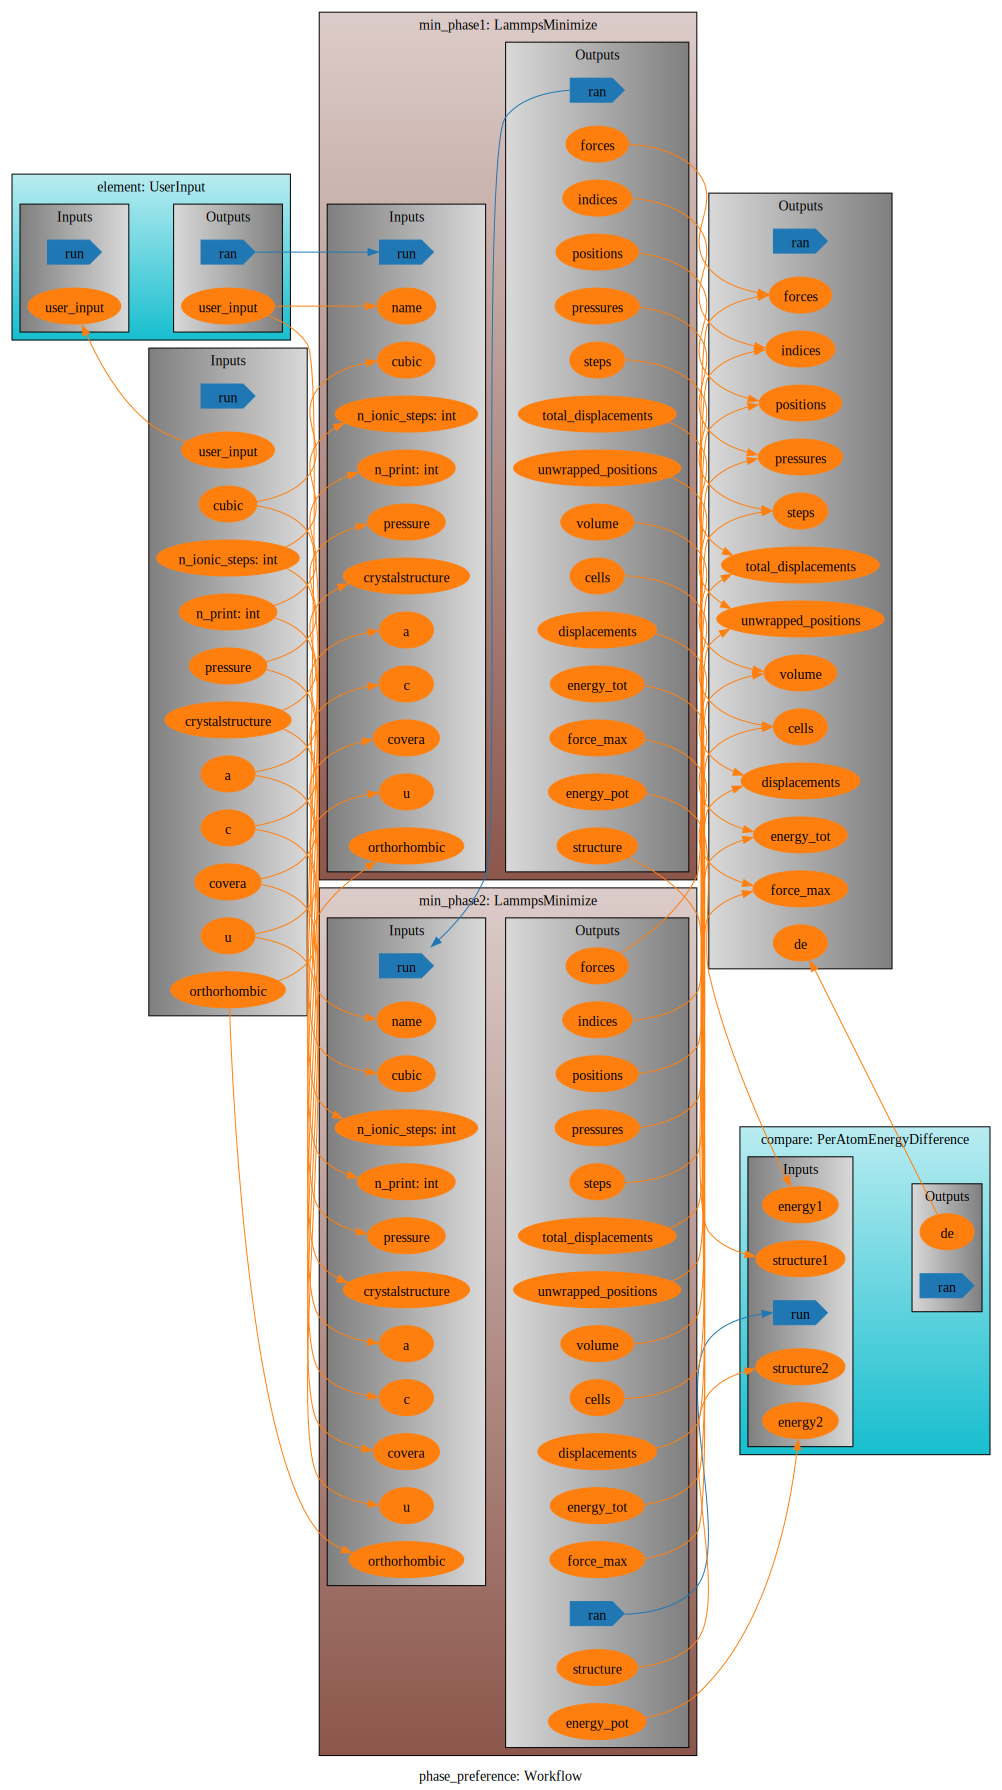

In [42]:
wf.draw()

In [43]:
out = wf(element="Al", phase1="fcc", phase2="hcp", lattice_guess1=4, lattice_guess2=4)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__de:.2f} eV/atom")

The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558
Al: E(hcp) - E(fcc) = 1.17 eV/atom


In [44]:
out = wf(element="Mg", phase1="fcc", phase2="hcp", lattice_guess1=3, lattice_guess2=3)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__de:.2f} eV/atom")

The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558
Mg: E(hcp) - E(fcc) = -4.54 eV/atom


# On the future

Currently things are at an intermediate state where we _always_ need to worry about specifying the execution flow with signals. While signals are a necessity for cyclic graphs, valid execution patterns can be determined _automatically_ from the topology of data connections in the case of a directed acyclic graph (DAG -- which includes all the workflows we've seen so far!) So in the near future you can look forward to this step being fully automated such that typical users _only_ need to worry about the data graph.

Additionally, we're working on better integration of executors so that processing power outside the main python process controlling the workflow can be used for individual nodes (including macros).

Finally, we will start working on serialization soon so that workflows can be saved/loaded/restarted.

(And, of course, there will be ongoing changes in UI/UX, like debug logs, more workflow visualization options, etc.)

# Here be dragons

While everything in the workflows sub-module is under development, the following complex features are _even more likely_ to see substantial modifications to their interface and behaviour. Nonetheless, they're fun so let's look at them.

## Meta-nodes and flow control

A meta-node is a function that produces a node _class_ instedad of a node _instance_.
Right now, these are used to produce parameterized flow-control nodes, which take an node class as input and return a new macro class that builds some graph using the passed node class, e.g. for- and while-loops.

### For-loops

One meta node is a for-loop builder, which creates a macro with $n$ internal instances of the "loop body" node class, and a new IO interface.
The new input allows you to specify which input channels are being looped over -- such that the macro input for this channel is interpreted as list-like and distributed to all the copies of the nodes separately --, and which is _not_ being looped over -- and thus interpreted as the loop body node would normally interpret the input and passed to all copies equally.
All of the loop body outputs are then collected as a list of length $n$.

We follow a convention that inputs and outputs being looped over are indicated by their channel labels being ALL CAPS.

In the example below, we loop over the bulk structure node to create structures with different lattice constants:

In [45]:
n = 5

bulk_loop = Workflow.create.meta.for_loop(
    Workflow.create.atomistics.Bulk,
    n,
    iterate_on=("a",),
)()

out = bulk_loop(
    name="Al",  # Sent equally to each body node
    A=np.linspace(3.9, 4.1, n).tolist(),  # Distributed across body nodes
)

[struct.cell.volume for struct in out.STRUCTURE]  
# output is a list collected from copies of the body node, as indicated by CAPS label

[14.829749999999995,
 15.407468749999998,
 15.999999999999998,
 16.60753125,
 17.230249999999995]

## While-loops

We can also create a while-loop, which takes both a body node and a condition node. The condition node must be a `SingleValue` returning a `bool` type. Instead of creating copies of the body node, the body node gets re-run until the condition node returns `False`.

You _must_ specify the data connection so that the body node passes information to the condition node. You may optionally also loop output of the body node back to input of the body node to change the input at each iteration. Right now this is done with horribly ugly string tuples, but we're still working on it.

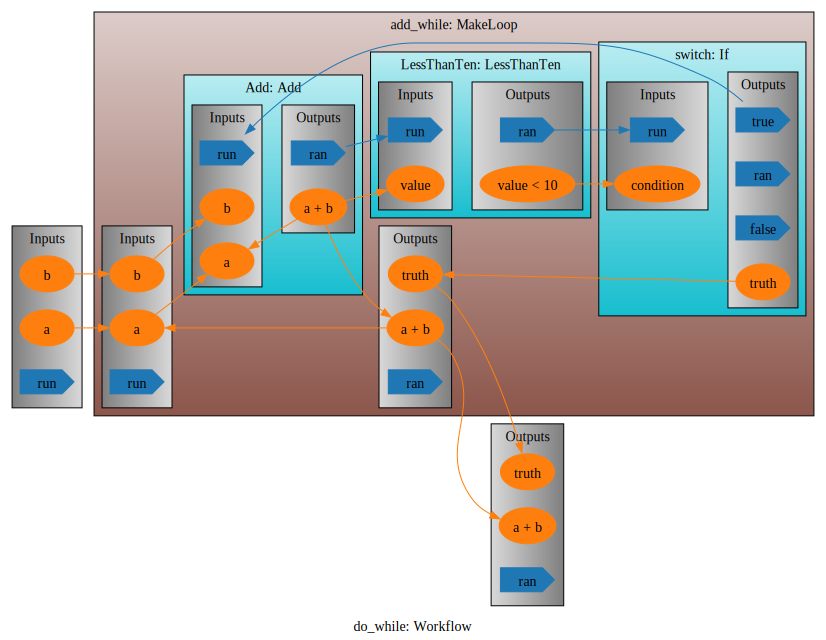

In [46]:
@Workflow.wrap_as.single_value_node()
def add(a, b):
    print(f"Adding {a} + {b}")
    return a + b

@Workflow.wrap_as.single_value_node()
def less_than_ten(value):
    return value < 10

AddWhile = Workflow.create.meta.while_loop(
    loop_body_class=add,
    condition_class=less_than_ten,
    internal_connection_map=[
        ("Add", "a + b", "LessThanTen", "value"),
        ("Add", "a + b", "Add", "a")
    ],
    inputs_map={"Add__a": "a", "Add__b": "b"},
    outputs_map={"Add__a + b": "total"}
)

wf = Workflow("do_while")
wf.add_while = AddWhile()

wf.starting_nodes = [wf.add_while]
wf.inputs_map = {
    "add_while__a": "a",
    "add_while__b": "b"
}
wf.outputs_map = {"add_while__total": "total"}

wf.draw(depth=2)

Note that initializing the `a` and `b` input to numeric values when we call the workflow below does not destroy the connection made between the body node input and output -- so the first run of the body node uses the initial value passed, but then it updates its own input for subsequent calls!

In [47]:
response = wf(a=1, b=2)
print("Finally", response.total)

Adding 1 + 2
Adding 3 + 2
Adding 5 + 2
Adding 7 + 2
Adding 9 + 2
Finally 11
